<a href="https://colab.research.google.com/github/SoyaOda/Complete-Python-3-Bootcamp/blob/master/2_2_1_2_multivariate(TIL%E7%97%87%E4%BE%8B)_numpy_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install logzero

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from logzero import logger

In [ ]:
df_label = pd.read_csv('/content/drive/MyDrive/NIFTI_Breast_Cancer_Prediction_Model/NIFTI/20220329Home_PC/Breast Cancer MRI/NIFTI Project/合算したCSV.csv')
#df_label = pd.read_csv('/content/drive/MyDrive/NIFTI_Breast_Cancer_Prediction_Model/NIFTI/20220329Home_PC/Breast Cancer MRI/NIFTI Project/ADCヒストグラムデータと他情報-Table 1.csv')
df_label = df_label[['OU_ID', 'pCRn0', '乳房pCR_without.DCIS', '乳房pCR_with.DCIS']]
df_label.head()

,OU_ID,pCRn0,乳房pCR_without.DCIS,乳房pCR_with.DCIS
0,OU_196,0,No,No
1,OU_195,0,Yes,Yes
2,OU_193,0,No,No
3,OU_189,0,No,No
4,OU_188,0,No,No


In [ ]:
df_label = pd.get_dummies(df_label, columns = ['乳房pCR_without.DCIS', '乳房pCR_with.DCIS'],drop_first=True)
df_label.head()

,OU_ID,pCRn0,乳房pCR_without.DCIS_Yes,乳房pCR_with.DCIS_Yes
0,OU_196,0,0,0
1,OU_195,0,1,1
2,OU_193,0,0,0
3,OU_189,0,0,0
4,OU_188,0,0,0


In [ ]:
df_feats = pd.read_csv('/content/drive/MyDrive/20220526乳癌Radiomics/ph2_feats2.csv')
df_feats.head()

,id,label,ph2_shape_Elongation,ph2_shape_Flatness,ph2_shape_LeastAxisLength,ph2_shape_MajorAxisLength,ph2_shape_Maximum2DDiameterColumn,ph2_shape_Maximum2DDiameterRow,ph2_shape_Maximum2DDiameterSlice,ph2_shape_Maximum3DDiameter,...,wavelet-LLL_gldm_GrayLevelNonUniformity,wavelet-LLL_gldm_GrayLevelVariance,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
0,OU_019,1,0.846373,0.739002,21.929981,29.675147,32.984845,31.622777,34.176015,37.363083,...,25.172156,323.163635,6208.786677,3.544910,23401.949850,0.001426,0.001015,0.650634,3856.691366,0.000958
1,OU_022,0,0.810753,0.781813,24.695237,31.587123,32.249031,36.496575,38.626416,38.832976,...,31.398104,354.013543,5167.315166,3.995261,23801.510664,0.005678,0.001553,0.627721,2895.274313,0.000585
2,OU_026,0,0.901613,0.819606,30.187227,36.831373,40.199502,41.231056,42.190046,43.312816,...,103.118361,93.496571,1925.336571,9.804249,18224.886798,0.006325,0.000982,0.368563,730.981984,0.000589
3,OU_028,0,0.927770,0.664032,12.707543,19.136946,21.540659,20.591260,21.633308,22.978251,...,6.755682,374.195732,5306.863636,4.232955,26885.755682,0.003758,0.003189,0.642696,3055.316782,0.003116
4,OU_031,0,0.691999,0.575107,11.823550,20.558864,22.360680,20.099751,20.396078,23.748684,...,6.917910,160.122452,1762.212687,3.305970,6200.772388,0.006592,0.005170,0.640392,1073.471911,0.004943


In [ ]:
import sys
ROOT_PATH = '/content/drive/MyDrive/20220506_2mm_resampling_Radiomics'
sys.path.append(ROOT_PATH)

import multiprocessing
import itertools
import utils
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif
import tqdm
from sklearn import feature_selection
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import FeatureAgglomeration

OUTER_SPLITS = 5
INNER_SPLITS = 5
SCALE_QUANTILE = 5
N_REPEAT = 10
INNER_REPEAT = N_REPEAT

import os
import re

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

sns.set(context="notebook", style="whitegrid", font="serif")
from matplotlib.pyplot import rcParams

rcParams["figure.figsize"] = 4, 4
import plot_utils as putils
import utils

MAX_ITER = 10000


In [ ]:
df_y_all = df_feats.iloc[:,1:2]
df_x = df_feats.iloc[:, 2:]
y = df_y_all.values
x = df_x.values
print(x.shape, y.shape)

(50, 1132) (50, 1)


In [45]:
import sys
ROOT_PATH = '/content/drive/MyDrive/20220506_2mm_resampling_Radiomics'
sys.path.append(ROOT_PATH)

import multiprocessing
import itertools
import utils
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif
import tqdm

OUTER_SPLITS = 5
INNER_SPLITS = 5
SCALE_QUANTILE = 5
N_REPEAT = 10
INNER_REPEAT = N_REPEAT


def nested_cv(x, y, clf, param_grid, random_state):
    random_state_generator = itertools.count(start=random_state, step=1)
    outer_cv = RepeatedStratifiedKFold(
        n_splits=OUTER_SPLITS,
        n_repeats=N_REPEAT,
        random_state=next(random_state_generator))
    n_classes = 2
    probas = []
    best_params, pipelines = [], []
    cv_scores, test_scores = [], []
    test_indices = []
    for outer_i, (train_index, test_index) in enumerate(
            tqdm.tqdm(outer_cv.split(x, y),
                      desc='Outer CV',
                      total=outer_cv.get_n_splits(x))):
        train_x, train_y = x[train_index], y[train_index]
        test_x, test_y = x[test_index], y[test_index]
        clf = LogisticRegression(
                penalty="l1",
                multi_class="ovr",
                solver="saga",
                max_iter=10000,
                n_jobs=1,
            )
        ppln = Pipeline([
            ('agglo',
                    FeatureAgglomeration()),
            # TODO: Should AgglomerativeClustering be used (without transposition)?
            ('scale',
                    RobustScaler()),
            # ('fs', utils.MySelectPercentile(f_regression)),
            ('clf', clf)
        ])
        # param_grid['fs__percentile'] = [25, 50]
        #         param_grid['fs__score_func'] = [mutual_info_classif,f_classif]
        inner_cv = RepeatedStratifiedKFold(
            n_splits=INNER_SPLITS,
            n_repeats=INNER_REPEAT,
            random_state=next(random_state_generator))
        grid_search = GridSearchCV(
            estimator=ppln,
            param_grid={"clf__C": [10, 1, 0.1]},
            cv=inner_cv,
            n_jobs=multiprocessing.cpu_count() - 1,
            scoring='roc_auc',
            refit=True)
        grid_search.fit(train_x, train_y)
        cv_scores.append(grid_search.best_score_)
        test_scores.append(grid_search.score(test_x, test_y))

        pipeline = grid_search.best_estimator_
        probas.append(pipeline.predict_proba(test_x))
        best_params.append(grid_search.best_params_)
        pipelines.append(pipeline)
        test_indices.append(test_index)
    print('test score mean and std')#, list(zip(cv_scores, test_scores)))
    print(np.mean(test_scores), np.std(test_scores))
    return np.concatenate(probas), np.concatenate(
        test_indices), pipelines, pd.DataFrame(
            utils.invert_list_dict(best_params))

In [47]:
#outdir = os.path.join(base_outdir, target_label, clf["name"])
#os.makedirs(outdir, exist_ok=True)
#clf["param_grid"] = {
    #"clf__" + key: value for key, value in clf["param_grid"].items()
#}
y_pred, test_indices, pipelines, best_params = nested_cv(
    x, y, clf, {"clf__C": [10, 1, 0.1]}, next(random_state_generator)
)


Outer CV:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/l

test score mean and std
0.46611111111111114 0.20298049228168102


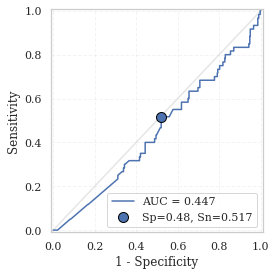

In [50]:
#joblib.dump(pipelines, os.path.join(outdir, "pipelines.joblib"), compress=3)
y_true = y[test_indices]
#best_params.to_csv(os.path.join(outdir, "params.csv"), index=False)
#np.save(os.path.join(outdir, "y_pred.npy"), y_pred)
#np.save(os.path.join(outdir, "y_true.npy"), y_true)
#np.save(os.path.join(outdir, "test_indices.npy"), test_indices)
xs, ys = putils.plot_roc(
    y_true,
    y_pred,
    average=False,
)
putils.plot_cutoff(xs, ys, index="youden")
plt.tight_layout()
plt.legend(loc="lower right")
#plt.gcf().savefig(
    #os.path.join(outdir, "roc_curve.svg"), bbox_inches="tight"
#)
plt.show()